# Calculate ciCOH Values: 

* For both normal and mild LFP data 

* Return phase [reachonset Touch] in single kluverboard task

* [29 31]Hz

## Import Packages

In [1]:
import os, sys
import scipy.io as sio
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import random
import pandas as pd
%matplotlib inline

In [2]:
# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# import util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import ciCoherence_overtime in connAnalyTool/synchronization_indices.ipynb
from connAnalyTool.synchronization_indices import ciCoherence_acrosstrials
from connAnalyTool.synchronization_indices import ciCoherence_overtime

importing Jupyter notebook from /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb


## Preparation

### exp subfolders & code_corresfolder

In [3]:
_, _, pipelinefolder, _= exp_subfolders()

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder, correparentfolder = code_corresfolder(os.getcwd(), nb_name)

### Global parameters

In [6]:
freq = [29, 31]

eventphase = 'return'

animal = 'Pinky'

tdur_min, tdur_max = 0.5, 1
tdur_reach = tdur_min

sameDates4SKTRest = True

In [7]:
coli_target, coli_reachonset, coli_touch, coli_returnonset, coli_mouth = 0, 1, 2, 3, 4


if eventphase == 'reach':
    cols = [coli_reachonset, coli_touch]
    
elif eventphase == 'return':
    cols = [coli_returnonset, coli_mouth]

### Input setup

In [8]:
inputfolder = os.path.join(pipelinefolder, 'NHP_Pinky', '0_dataPrep', 'SKT', 
                           'm3_STKData_narrowfiltered' + str(freq[0]) + '_' + str(freq[1]))

In [9]:
variablesinLoadfile = ['lfpdata', 'idxevent_Matrix', 'idxevent_vNames', 'fs', 
                   'chans_m1', 'GMChnAreas']

In [10]:
chnInf_folder = correparentfolder
chnInf_file = os.path.join(chnInf_folder, 'chn_brainArea_simCoord_M1ThaSMADBS.csv')

In [11]:
if sameDates4SKTRest:
    
    sameDatesInfFile = os.path.join(pipelinefolder, 'NHP_Pinky', '0_dataPrep', 'Pinky_sameDatesUsedforSTKRest.csv')

### Save setup

In [12]:
savefolder = corresfolder
savefilename =  'ciCOH_STK_' + 'freq_' + str(freq[0]) + '_' + str(freq[1]) + '_' + eventphase 


if sameDates4SKTRest:
    savefilename = savefilename + '_samedays'

## Extract lfp & chnInf 

### Extract lfp

In [13]:
def lfpallfiles_extract(files):
    if 'lfpdata' in locals():
        del lfpdata
        
        
    for filei, file in enumerate(files):
    
        # load the stk trial data in alpha band with idxevent, idxevent_varNames, fs
        matdat = sio.loadmat(file, 
                             variable_names = variablesinLoadfile, 
                             struct_as_record = False, squeeze_me = True)
        # fs: sample rate
        fs = matdat['fs'] 
                
        
        ### extract the noused channels, only calculate once
        if filei == 0:
            GMChnAreas = matdat['GMChnAreas'].tolist()
            chni_notused = []
            for chni, area in enumerate(GMChnAreas):
                if len(area) == 0:
                    # this channel is not used for any area
                    chni_notused.append(chni)
                    
            # remove the used channels from GMChnAreas and chans_GM
            chans_GM = [*range(101, 133,1)]
            for idx in sorted(chni_notused, reverse=True):
                del GMChnAreas[idx]
                del chans_GM[idx]
                
            # chnInf_recchni
            recchni_used = matdat['chans_m1'].tolist() + chans_GM + [*range(0, 7,1)] + [*range(0, 7,1)]
        

        ### dealing lfp data
            
        lfp = matdat['lfpdata']
        
        # idxevent (np.ndarray, ntrials * 5) indices for targetonset, reachonset, reach, return and mouth
        idxevent = matdat['idxevent_Matrix']
        

        idxdur_min, idxdur_max = int(np.round(tdur_min * fs)), int(np.round(tdur_max * fs))
        idxdur_reach = int(np.round(tdur_reach * fs))

        if len(lfp.shape) == 2: # only has one trial
            lfp = np.expand_dims(lfp, axis = 2)
            idxevent = np.expand_dims(idxevent, axis = 0)

        ntrials = lfp.shape[2]

        # deal each trial in lfp of one file
        for triali in range(ntrials):

            # start and end indices over time of specific phase for triali 
            idxtime_str, idxtime_end = int(idxevent[triali][cols[0]]), int(idxevent[triali][cols[1]])    

            # remove trials of return phase longer than tdur_max and shorter than tdur_min
            if idxtime_end - idxtime_str < idxdur_min or idxtime_end - idxtime_str > idxdur_max:
                continue;


            # extract lfp data in specific phase of one trial (n_chns * n_times)
            lfp_1trial = np.expand_dims(lfp[:, idxtime_str:idxtime_str + idxdur_reach, triali], axis=2)       


            # append new trial to lfpdata
            if 'lfpdata' not in locals():
                lfpdata = lfp_1trial
            else:
                lfpdata = np.concatenate((lfpdata, lfp_1trial), axis = 2)

            del lfp_1trial, idxtime_str, idxtime_end

        del matdat, fs, idxevent, lfp
        
        
        
    return lfpdata, recchni_used

In [14]:
files_normal = glob.glob(os.path.join(inputfolder, '*_normal_*'))
files_mild = glob.glob(os.path.join(inputfolder, '*_mild_*'))


if sameDates4SKTRest: ## extract only the file with the dates used in datestrings_rest
    
    df = pd.read_csv(sameDatesInfFile)
    
    datestrings_rest = df['datestrings_skt']
    
    
    
    files = files_normal
    files_used = []
    for file in files:

        # extract the date string for the file, format '_20170915_'
        idx = file.find('_bktdt')
        datestring = '_' + file[idx-6:idx] + '_'

        # if the date in datestrings_rest
        if datestring in set(datestrings_rest):
            files_used.append(file)

    files_normal = files_used
    del files_used


    files = files_mild
    files_used = []
    for file in files:

        # extract the date string for the file, format '_20170915_'
        idx = file.find('_bktdt')
        datestring = '_' + file[idx-6:idx] + '_'

        # if the date in datestrings_rest
        if datestring in set(datestrings_rest):
            files_used.append(file)

    files_mild = files_used
    del files_used

In [15]:
# lfptrials_normal, lfptrials_mild: nchns * ntemp * ntrials
lfptrials_normal, recchni_used = lfpallfiles_extract(files_normal)
lfptrials_mild, _ = lfpallfiles_extract(files_mild)

In [16]:
print(lfptrials_mild.shape)
print(lfptrials_normal.shape)

(93, 250, 116)
(93, 250, 107)


### Extract chnInf using recchni_used

In [17]:
### load channel information ###
df = pd.read_csv(chnInf_file, header = 0)

In [18]:
# recording chni 
recording_chni = df['recording_chni'].tolist()

chnInf_brainarea = df['brainarea']
chnInf_matchni = df['mat_chni']

# coord
x, y = df['simulated_x'].to_numpy(), df['simulated_y'].to_numpy()
chnInf_coord = np.concatenate((np.expand_dims(x, axis = 1), np.expand_dims(y, axis = 1)), axis = 1)

In [19]:
### extract the idx_used in list recording_chni
idx_used = []
# get the idx_used for m1 and GM (i.e. except stn and gp) in list recording_chni
for i, rechni in enumerate(recchni_used[0:-14]):
    idx_used.append(recording_chni.index(rechni))
    
# get idx of stn and gp (i.e. the last 14 channels)
idx_used = idx_used + [*range(len(recording_chni)-14, len(recording_chni))]

In [20]:
# get chnInf for used channels
chnInf_brainarea = chnInf_brainarea[idx_used].tolist()
chnInf_coord = chnInf_coord[idx_used,:]
chnInf_matchni = chnInf_matchni[idx_used]

chnInf_recchni = recchni_used

## Calculate ciCOH

### balance mild and normal trials

In [21]:
# select the smaller trial number
ntrials_normal, ntrials_mild = lfptrials_normal.shape[2], lfptrials_mild.shape[2]
ntrials = min([ntrials_normal, ntrials_mild])

# balance trials
lfptrials_normal = lfptrials_normal[:,:,0:ntrials]
lfptrials_mild = lfptrials_mild[:,:,0:ntrials]

###  normal ciCOH

In [22]:
lfptrials = lfptrials_normal

### calculate ciCOH
nchns = lfptrials.shape[0]
ciCOH = np.zeros((nchns, nchns))

for chni in range(nchns-1):
    
    # signal of channel chni
    signal1 = lfptrials[chni, :, :]
    
    for chnj in range(chni+1, nchns):
        
         # signal of channel chnij
        signal2 = lfptrials[chnj, :, :]
        
        # ciCOH assignment
        ciCOH[chni, chnj] =  np.mean(ciCoherence_acrosstrials(signal1, signal2))

        # symmetrical
        ciCOH[chnj, chni] = ciCOH[chni, chnj]

        del signal2
    del signal1
    
ciCOH_normal = ciCOH
del ciCOH, lfptrials, nchns

### mild ciCOH

In [23]:
lfptrials = lfptrials_mild

### calculate ciCOH
nchns = lfptrials.shape[0]
ciCOH = np.zeros((nchns, nchns))

for chni in range(nchns-1):
    
    # signal of channel chni
    signal1 = lfptrials[chni, :, :]
    
    for chnj in range(chni+1, nchns):
        
         # signal of channel chnij
        signal2 = lfptrials[chnj, :, :]
        
        # ciCOH assignment
        ciCOH[chni, chnj] =  np.mean(ciCoherence_acrosstrials(signal1, signal2))

        # symmetrical
        ciCOH[chnj, chni] = ciCOH[chni, chnj]

        del signal2
    del signal1
    
ciCOH_mild = ciCOH
del ciCOH, lfptrials, nchns

## save

In [24]:
ciCOH = dict()
ciCOH['normal'], ciCOH['mild'] = ciCOH_normal, ciCOH_mild
ciCOH['chnInf_recchni'], ciCOH['chnInf_matchni'] = chnInf_recchni, chnInf_matchni
ciCOH['chnInf_brainarea'], ciCOH['chnInf_coord'] = chnInf_brainarea, chnInf_coord 

In [25]:
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

with open(os.path.join(savefolder, savefilename + '.pickle'), 'wb') as fp:
    pickle.dump(ciCOH, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
os.path.join(savefolder, savefilename + '.pickle')

'/home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/FCAnaly/SKT/m1_SKT_calcciCOH_Fre29-31Hz_return/ciCOH_STK_freq_29_31_return_samedays.pickle'

## plot section

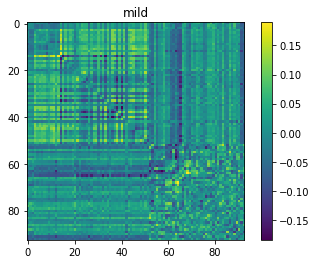

In [27]:
plt.imshow(ciCOH['mild']);
plt.colorbar()
plt.title('mild')
plt.show()

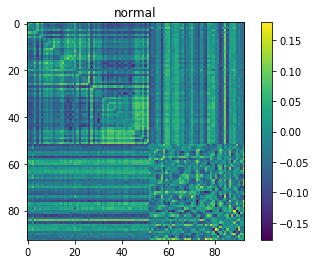

In [28]:
plt.imshow(ciCOH['normal'])
plt.title('normal')
plt.colorbar()
plt.show()